# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  7.760784149169922
load_data: FFT of data, time:  9.215047836303711


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 64 x 64 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


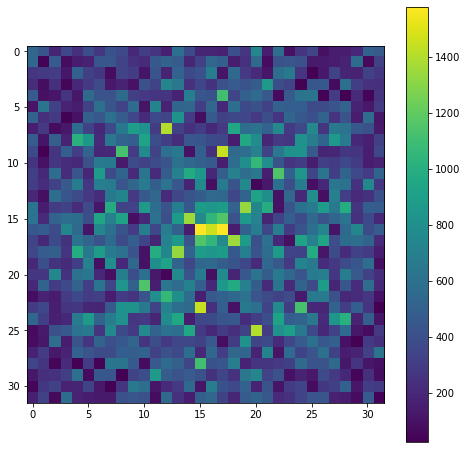

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

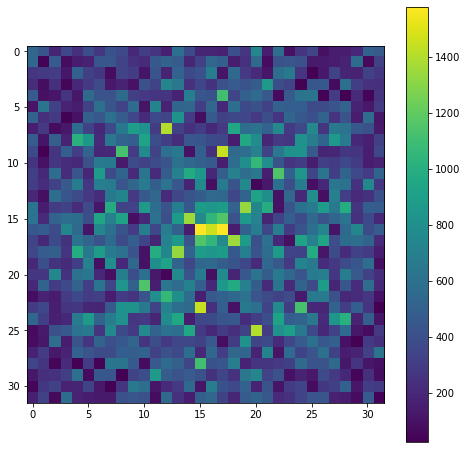

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

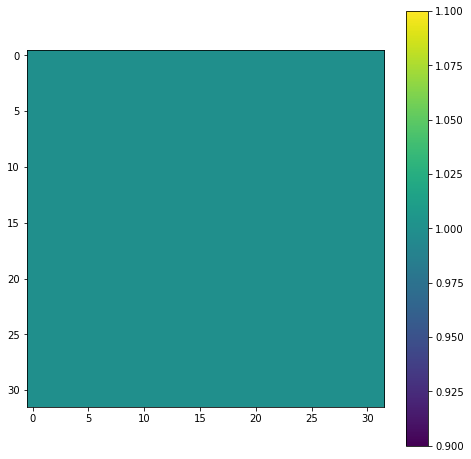

In [12]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

2.4720311164855957
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

2.6497859954833984
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

  cg iter 0 ||r|| = 0.14512908369510366
  cg iter 50 ||r|| = 0.0004405018950297914
  cg iter 100 ||r|| = 0.00031429399976094894


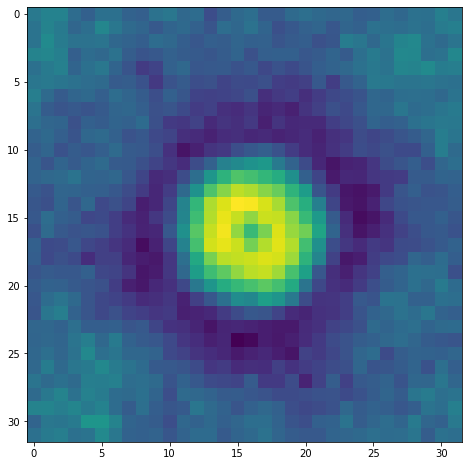

Iter  0
  Time orientations sampling = 2.712765693664551
  cg iter 0 ||r|| = 0.41387207464855436
  cg iter 50 ||r|| = 0.0004933778554494937
  cg iter 100 ||r|| = 0.000290193735149939
  Time cg = 11.972156763076782


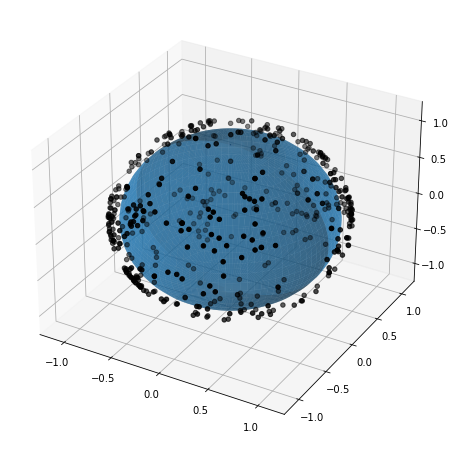

Iter  1
  Time orientations sampling = 2.660876750946045
  cg iter 0 ||r|| = 0.3289747931626255
  cg iter 50 ||r|| = 0.0005306988784330742
  cg iter 100 ||r|| = 0.0003447513599128144
  Time cg = 15.20393180847168
Iter  2
  Time orientations sampling = 2.621675968170166
  cg iter 0 ||r|| = 0.3611254344755103
  cg iter 50 ||r|| = 0.0006232666554252426
  cg iter 100 ||r|| = 0.0004296538206709594
  Time cg = 15.814579248428345
Iter  3
  Time orientations sampling = 2.7273547649383545
  cg iter 0 ||r|| = 0.41280195373476547
  cg iter 50 ||r|| = 0.0005477212221914554
  cg iter 100 ||r|| = 0.00042331177187802764
  Time cg = 15.555524587631226
Iter  4
  Time orientations sampling = 2.569182872772217
  cg iter 0 ||r|| = 0.4485132749554973
  cg iter 50 ||r|| = 0.0008284693309304636
  cg iter 100 ||r|| = 0.00041133066631118944
  Time cg = 17.020951509475708


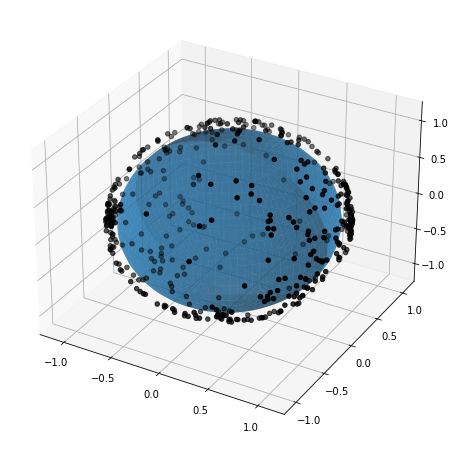

Iter  5
  Time orientations sampling = 2.5608770847320557
  cg iter 0 ||r|| = 0.42471574454539296
  cg iter 50 ||r|| = 0.0008621141714703079
  cg iter 100 ||r|| = 0.0004355871575994496
  Time cg = 18.474299430847168
Iter  6
  Time orientations sampling = 2.7134883403778076
  cg iter 0 ||r|| = 0.43392199731768333
  cg iter 50 ||r|| = 0.0006642484751482255
  cg iter 100 ||r|| = 0.000443552205642817
  Time cg = 19.099392414093018
Iter  7
  Time orientations sampling = 2.557680130004883
  cg iter 0 ||r|| = 0.4426806220643699
  cg iter 50 ||r|| = 0.0006254350639269768
  cg iter 100 ||r|| = 0.00046801541427261796
  Time cg = 19.080660343170166
Iter  8
  Time orientations sampling = 2.7145423889160156
  cg iter 0 ||r|| = 0.4526715147201356
  cg iter 50 ||r|| = 0.0008743511998620765
  cg iter 100 ||r|| = 0.0005262559658218993
  Time cg = 19.048118591308594


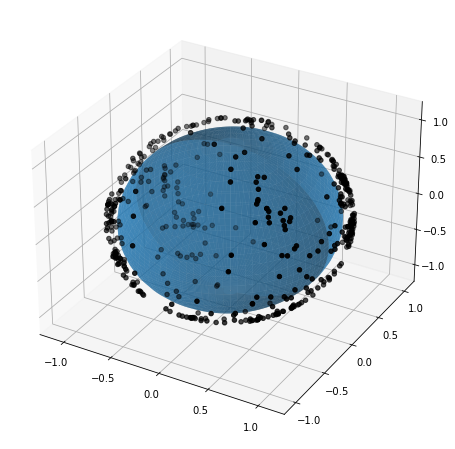

Iter  9
  Time orientations sampling = 2.551664113998413
  cg iter 0 ||r|| = 0.3656644123458898
  cg iter 50 ||r|| = 0.0008506382992134234
  cg iter 100 ||r|| = 0.0005889202363966575
  Time cg = 24.42402958869934
Iter  10
  Time orientations sampling = 2.490074872970581
  cg iter 0 ||r|| = 0.37577295392161814
  cg iter 50 ||r|| = 0.0008932691026929702
  cg iter 100 ||r|| = 0.00043659429823968154
  Time cg = 24.14480471611023
Iter  11
  Time orientations sampling = 2.8113620281219482
  cg iter 0 ||r|| = 0.367511653666262
  cg iter 50 ||r|| = 0.0007899122883857105
  cg iter 100 ||r|| = 0.0005415593549093869
  Time cg = 24.293235063552856
Iter  12
  Time orientations sampling = 2.875406265258789
  cg iter 0 ||r|| = 0.3545004288163017
  cg iter 50 ||r|| = 0.0007911549530933532
  cg iter 100 ||r|| = 0.000495061658678156
  Time cg = 24.15633726119995


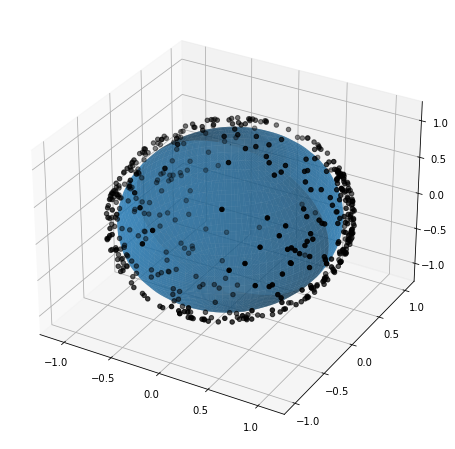

Iter  13
  Time orientations sampling = 2.58335018157959
  cg iter 0 ||r|| = 0.3078582483507908
  cg iter 50 ||r|| = 0.0010253758826805524
  cg iter 100 ||r|| = 0.0005811688676653155
  Time cg = 24.49648404121399


In [43]:
N_samples = 40000
N_iter = 100
N_cg_iter = 101
dr = 0.005
#radius = 0.01
radius = 0.03
alpha = 0.001

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])
vcg = ab_initio(project, imgs_f, shifts, ctf_params, x_grid, N_iter, N_cg_iter, N_samples, radius, dr, alpha, 'tri', True, True, True, out_dir)

### CG

In [20]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 20

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [21]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.05097052279774336


In [22]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [ ]:
i = 110
s0 = slice_func(vcg1, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

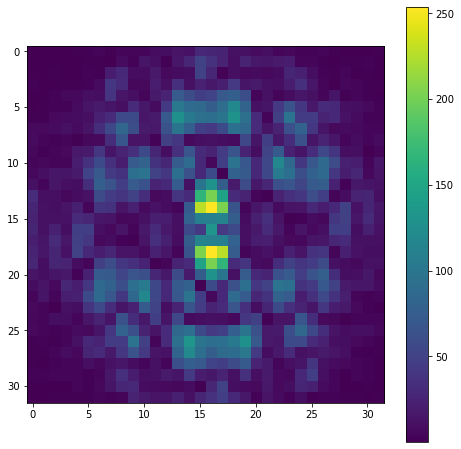

In [24]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

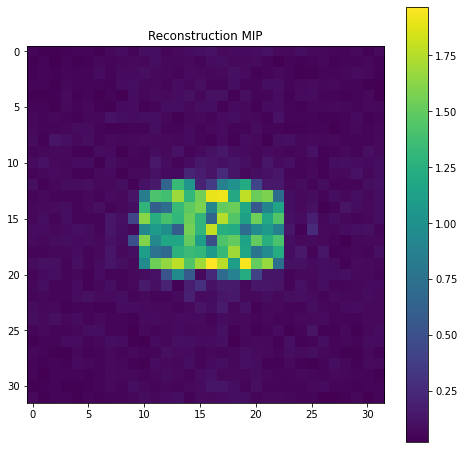

In [25]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [26]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

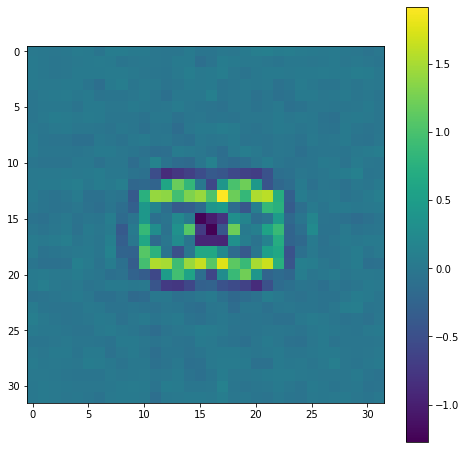

In [27]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

### Write volume to file

In [28]:
#with mrcfile.new('../data/reconstruction_data_32.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


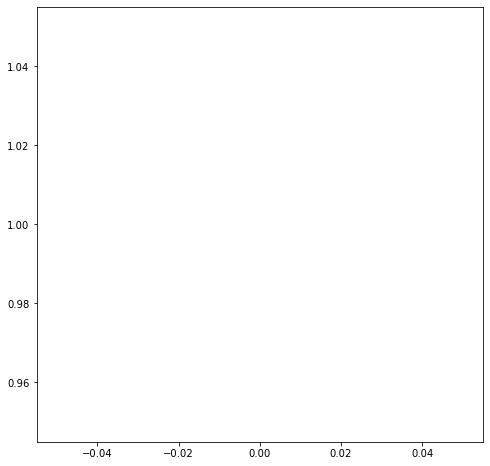

In [31]:
plt.plot(res,fsc)

In [32]:
points_v_tri = points_orientations_tri(angles[:50], x_grid[1])

KeyboardInterrupt: 

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()